In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 2 1 0 0]


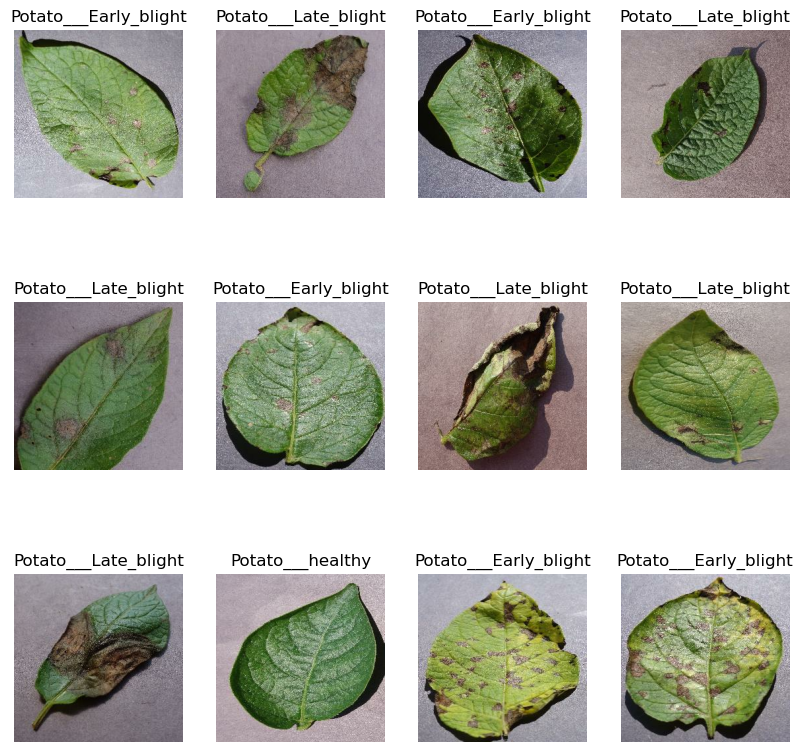

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [11]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [12]:
test_dataset = dataset.skip(54)
len(test_dataset)

14

In [13]:
validation_dataset = test_dataset.take(6)
len(validation_dataset)

6

In [14]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [15]:
def get_dataset_partition(dataset, train_split=0.8, validation_split=0.1, test_split=0.1, shuffle=True,
                          shuffle_size=10000):
    dataset_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * dataset_size)
    val_size = int(validation_split * dataset_size)

    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    return train_dataset, validation_dataset, test_dataset

In [16]:
train_dataset, validation_dataset, test_dataset = get_dataset_partition(dataset)

In [17]:
len(train_dataset)

54

In [18]:
len(validation_dataset)

6

In [19]:
len(test_dataset)

8

In [20]:
train_dataset = train_dataset.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [24]:
model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:
model.fit(train_dataset, epochs=50, batch_size=BATCH_SIZE, verbose=1, validation_data=validation_dataset)

Epoch 1/50
54/54 [==============================] - 59s 800ms/step - loss: 0.8892 - accuracy: 0.5231 - val_loss: 0.8797 - val_accuracy: 0.5625
Epoch 2/50
54/54 [==============================] - 19s 358ms/step - loss: 0.6746 - accuracy: 0.7292 - val_loss: 0.5459 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 15s 283ms/step - loss: 0.5028 - accuracy: 0.7714 - val_loss: 0.3992 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 14s 262ms/step - loss: 0.3145 - accuracy: 0.8744 - val_loss: 0.3609 - val_accuracy: 0.8385
Epoch 5/50
54/54 [==============================] - 12s 224ms/step - loss: 0.3017 - accuracy: 0.8738 - val_loss: 0.2684 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 11s 209ms/step - loss: 0.2399 - accuracy: 0.9091 - val_loss: 0.3142 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 12s 213ms/step - loss: 0.2025 - accuracy: 0.9172 - val_loss: 0.2825 - val_accuracy: 0.8906

In [28]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 14s 74ms/step - loss: 0.0788 - accuracy: 0.9766


In [29]:
scores

[0.0787864625453949, 0.9765625]

In [30]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 14s 261ms/step - loss: 0.0328 - accuracy: 0.9873 - val_loss: 0.3484 - val_accuracy: 0.8802
Epoch 2/50
54/54 [==============================] - 11s 210ms/step - loss: 0.0602 - accuracy: 0.9769 - val_loss: 0.2067 - val_accuracy: 0.9271
Epoch 3/50
54/54 [==============================] - 11s 203ms/step - loss: 0.0340 - accuracy: 0.9878 - val_loss: 0.0713 - val_accuracy: 0.9792
Epoch 4/50
54/54 [==============================] - 11s 211ms/step - loss: 0.0104 - accuracy: 0.9965 - val_loss: 0.1070 - val_accuracy: 0.9531
Epoch 5/50
54/54 [==============================] - 11s 204ms/step - loss: 0.0204 - accuracy: 0.9919 - val_loss: 0.6407 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 11s 204ms/step - loss: 0.0385 - accuracy: 0.9902 - val_loss: 0.2284 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 11s 202ms/step - loss: 0.0245 - accuracy: 0.9902 - val_loss: 0.4340 - val_accuracy: 0.8906

In [31]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 4s 451ms/step - loss: 0.1095 - accuracy: 0.9648


In [32]:
scores

[0.10950154066085815, 0.96484375]

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
type(history.history['loss'])

list

In [37]:
len(history.history['loss'])

50

In [38]:
history.history['loss'][:5]

[0.03276289999485016,
 0.06024956703186035,
 0.03398426994681358,
 0.010438480414450169,
 0.020364977419376373]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

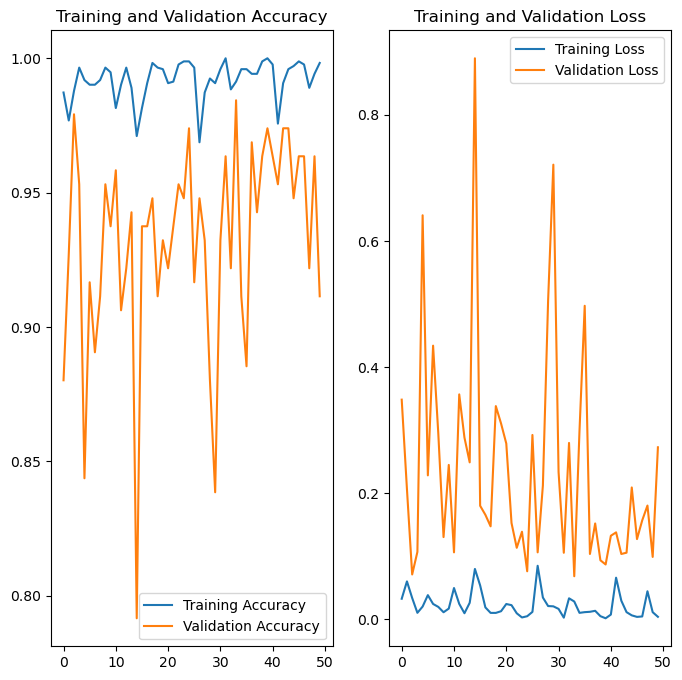

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 1s 626ms/step
Predicted label: Potato___Early_blight


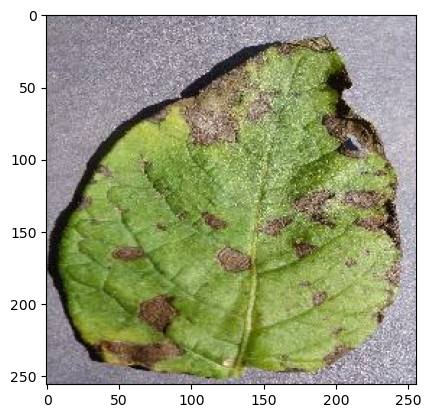

In [41]:
import numpy as np

for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


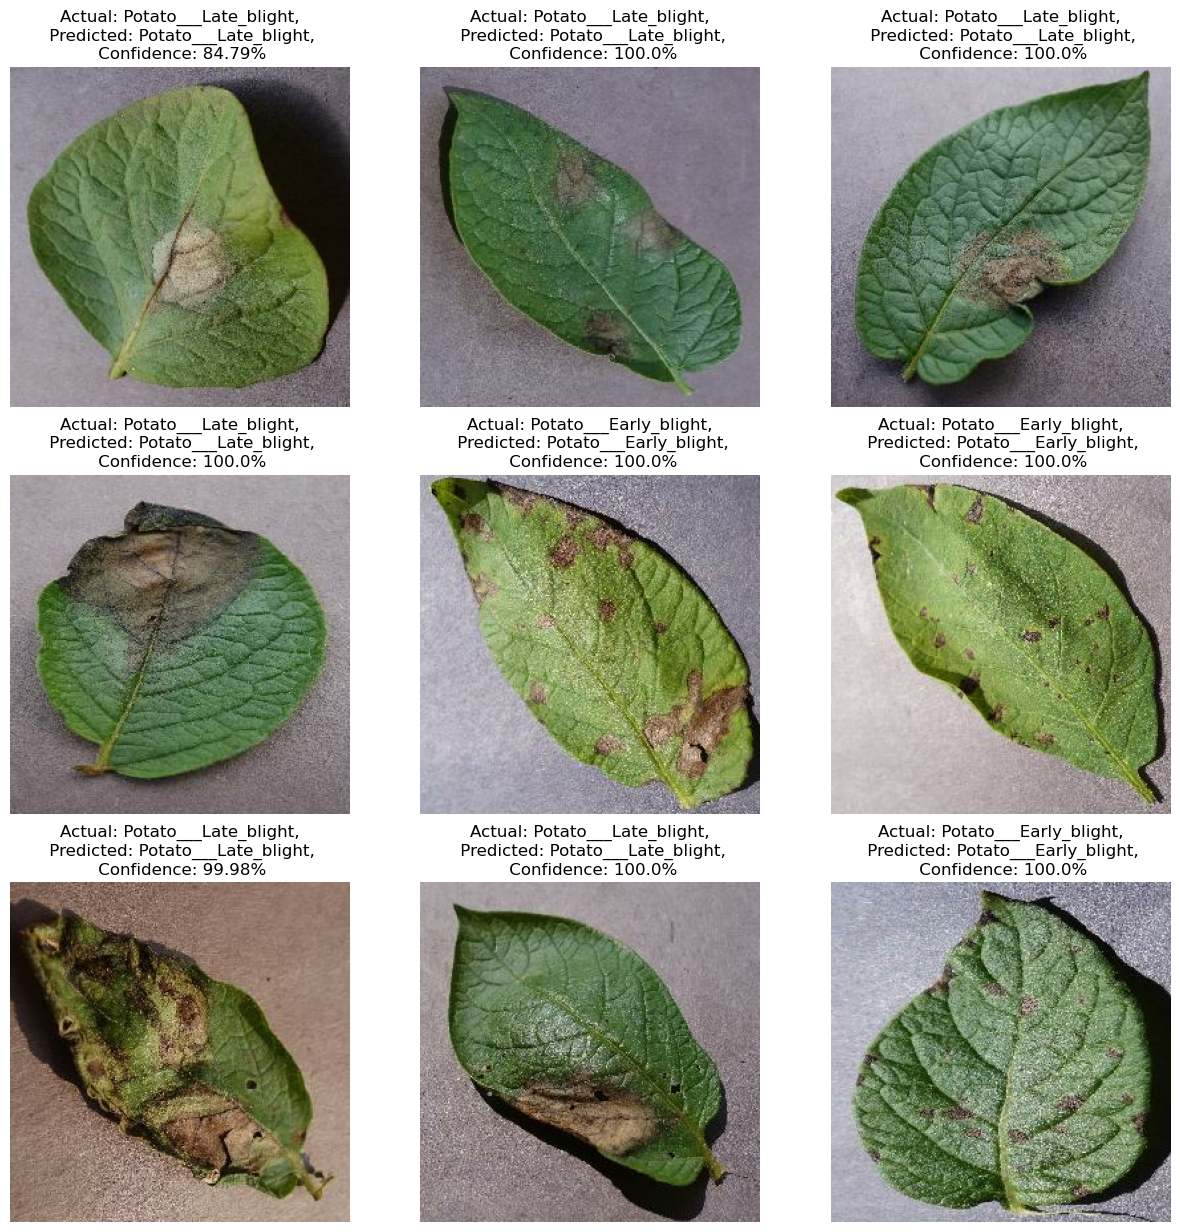

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")

        plt.axis("off")

In [46]:
import os

model_version = max([int(i) for i in os.listdir("../saved_models") + [0]]) + 1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets
